# Sub mm Precision

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/FMCW_MIMO_101_sub_mm_precision.ipynb)

## The problem

Multiple systems exhibit sub-mm precision (i.e. precision lower than 1 mm), yet the FMCW basics is that resolution is a function of the chirp bandwidth. 

Antenna designs often limits bandwidth to sub 10-GHz which effectively limits resolution to 3 cm.


## The solution

Instead of using the frequency of the FFT bin, use a frequency estimator with higher precision. While it will not be possible to resolve two targets with better than the FFT range resolution, it will be possible to increase precision of the estimated frequency.

Small list of possible algorithms are:
* simple FFT
* FFT with zero padding
* Quinn's second interpolation [1]
* Phase based interpolation

[1] Quinn, BG, "Estimation of frequency, amplitude and phase from the DFT of a time series," IEEE Trans. Sig. Proc. Vol 45, No 3, Mar 1997, pp814-817.

In [ ]:
# Install a pip package in the current Jupyter kernel
# Recommended when running from Google Colab or similar environment
import sys
!{sys.executable} -m pip install mmWrt


In [1]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import arange, where, expand_dims

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

### Frequency Estimator for sub-mm precision

Below is just an example with nominal values. For a more comprehensive analysis, noise sensitivity (phase noise in RX channel), channel noise and other aspects would need to be considered.

For embedded systems, a zoom FFT, can be used to reduce the memory needed for the full FFT to be computed.

Overview - Comparing 

> FFT estimator ($ \approx $ 2 cm) 

vs 

> Quinn2 estimator ($ \approx 4 \mu m$)


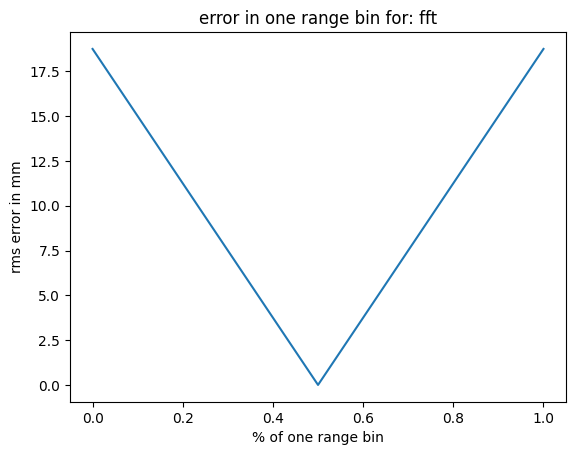

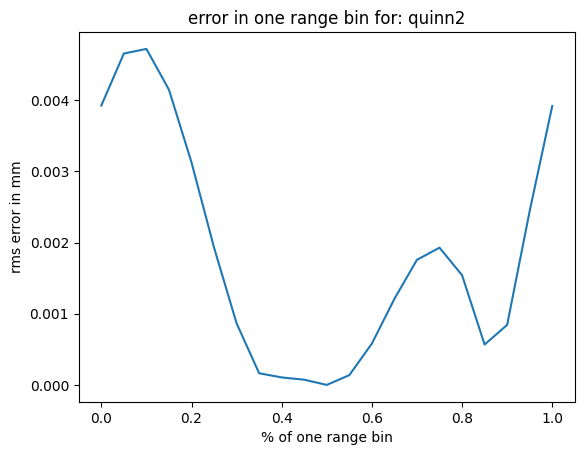

In [4]:
c = 3e8

debug_ON = True
test = 0
k = 50e8
radar = Radar(transmitter=Transmitter(bw=4e9, slope=k, chirps_count=1),
              receiver=Receiver(fs=10.24e3, max_adc_buffer_size=9000,
                                debug=debug_ON), debug=debug_ON)

for est in ["fft", "quinn2"]:
    increments_count = 20
    errors_in_mm = []
    deltas = []
    for increment in range(increments_count+1):
        delta = increment /increments_count
        deltas.append(delta*100)
        d0 = radar.range_bin * 999.5
        d1 = d0 +  radar.range_bin * delta
        target1 = Target(d1)

        targets = [target1]

        bb = rt_points(radar, targets, debug=debug_ON)

        Distances, range_profile = rsp.range_fft(bb)
        ca_cfar = rsp.cfar_ca_1d(abs(range_profile))

        mag_r = abs(range_profile)
        mag_c = abs(ca_cfar)
        # little hack to remove small FFT ripples : mag_r> 10
        target_filter = ((mag_r > mag_c) & (mag_r > 10))

        index_peaks = where(target_filter)[0]
        
        grouped_peaks = rsp.peak_grouping_1d(index_peaks, mag_r)
        ipeaks = rsp.frequency_estimator(range_profile, grouped_peaks,
                                        estimator_name=est)
        f2d = c/2/k * radar.fs/radar.n_adc
        distances = f2d * ipeaks
        found_targets = [Target(d) for d in distances]
        error = rsp.error(targets, found_targets)
        if error>2:
            print("????", gpeaks, grouped_peaks, error)
        errors_in_mm.append(error*1e3)

    plt.plot(deltas, errors_in_mm)
    # plt.plot(Distances, mag_c)
    plt.title(f"error in one range bin for: {est}")
    plt.xlabel('% of one range bin')
    plt.ylabel('rms error in mm')
    plt.show()